In [2]:
# Import general packages.

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from typing import List
from skimage import exposure

tfe = tf.contrib.eager

tf.enable_eager_execution()

In [3]:
# Import project libraries.

import sys
sys.path.insert(0, '/Users/noah/Documents/CHU/Ultrasound/lib/')

from image_registration import loss_utils
from image_registration import load_image
from image_registration import warp
from image_registration import elastic_image
from image_registration import warp_utils
from image_registration import rigid_registration
from image_registration import elastic_image_utils

from image_utils import visualization_utils




In [4]:
dataset_path = "/Users/noah/Documents/CHU/Ultrasound/raw_data/heart_rotation"

save_dir = "/Users/noah/Documents/CHU/Ultrasound/experiment_results/9_17_registration"

if not os.path.exists(save_dir):
  os.makedirs(save_dir)

images_file = os.path.join(dataset_path, 'raw_images.npy')
data_temp = np.load(images_file).astype(np.float32)

print(data_temp.shape)



(9, 623, 512)


In [5]:
def load_image_demons(
    image: tf.Tensor,
    rotation,
    translation,
):
  """Creates ElasticImage object with variables for image flow 
  demons registration.

  Args:
    image: tf.Tensor of shape [height, width].
    initial_non_rigid_values_or_scale: Either a List of intial displacements
      control_point grid or a float which parameterizes the scale of random
      initialization. See `warp_parameters.make_elastic_warp_variable`.


  R
  eturns:
    ElasticImage object containing image and variables for each
    point displacement.
  """
    
  xx, yy = np.meshgrid(np.arange(image.shape[0]),
                       np.arange(image.shape[1]))

  control_points = np.stack([xx, yy], -1)
  control_points = np.reshape(control_points, [-1, 2])

  control_points = tf.convert_to_tensor(control_points, tf.float32)

  return load_image.load_image(image, control_points, rotation, translation, 1.)

In [6]:
# add noise to images (may want to do this as layer)
def gaussian_noise_layer(input_layer, std):
    "Adds noise > 0"
    noise = tf.truncated_normal(shape=tf.shape(input_layer), mean= 2 * std, stddev=std, dtype=tf.float32) 
    return input_layer + noise

In [7]:


def compare_images(
    image_a,
    image_b
    ):
    
    image_a_warp = warped_image(image_a, True)
    
    image_b_warp = warped_image(image_b, True)
    image_b_before_registration = warped_image(image_b, False)
    
    fig, ax = plt.subplots(1,2, figsize=(15,15))
    ax[0].imshow(visualization_utils.multiple_intensity_to_rgb(image_a_warp, image_b_before_registration))
    ax[1].imshow(visualization_utils.multiple_intensity_to_rgb(image_a_warp, image_b_warp))
    fig.savefig(os.path.join(save_dir, "warped_image"))



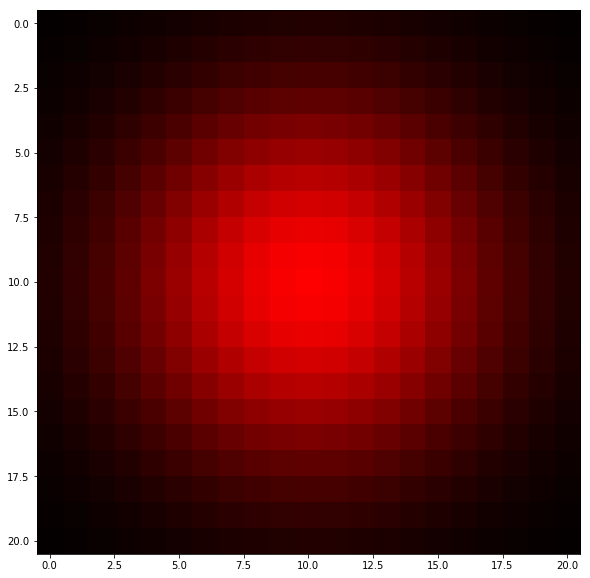

In [8]:
# 2D Gaussian Kernel
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tf.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
    gauss_kernel = tf.stack([gauss_kernel, tf.zeros_like(gauss_kernel)], axis=2)
    gauss_kernel = tf.stack([gauss_kernel, gauss_kernel[:, :, ::-1]], axis=3)
    return gauss_kernel

gauss_kernel = gaussian_kernel(10, 0., 5.)

plt.figure(figsize=(20,10))
plt.imshow(visualization_utils.multiple_intensity_to_rgb(gauss_kernel[:,:,0,0].numpy()))

In [9]:
def _grid_convolve(tensor, correlation_kernel):
    """Convolves tensor with kernel.

    Args:
        tensor: Tensor of shape [N, W, H, 2].
        correlation_kernel: Kernel to evaluate correlation.  Shape [C, C, 2, 2]

    Returns:
        convolved: tensor convolved with correlation_kernel
    """
    # Symmetric padding ensures that tensors along the edge are not penalized
    pad_size = ( gauss_kernel.shape.as_list()[0] - 1 ) / 2

    tensor = tf.pad(tensor, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode="SYMMETRIC")
    
    return  tf.nn.conv2d(tensor, correlation_kernel, strides=[1, 1, 1, 1], padding="VALID")



In [10]:
def demons_register(
    image_a,
    image_b,
    num_steps = 20,
):
    for _ in range(num_steps):
        time_step_start = time.time()
        # WARP IMAGES

        # Moving image.
        # warped_values is list of tf.Tensor for each image
        warp_values = []

        # Demons displacement.
        prepared_warp_values = warp_utils.warp_tensor(image_a, True, True, True)

        # Reshape for dense warp.
        prepared_warp_values[0] = tf.reshape(
            prepared_warp_values[0], [image_a.image.shape[0], image_a.image.shape[1], 2])
        prepared_warp_values[2] = tf.reshape(
            prepared_warp_values[2], [image_a.image.shape[0], image_a.image.shape[1], 2])


        [tf.expand_dims(tensor, 0) for tensor in prepared_warp_values]

        time_warp_start = time.time()
        m = warp.dense_warp(
            image_a.image[tf.newaxis, :, :, tf.newaxis], warp_values)

        print("time to warp {}".format(time.time() - time_warp_start))


        # Stationary Image
        s = image_b.image[tf.newaxis, :, :, tf.newaxis]
        
        time_calculation_start = time.time()
        # IMAGE GRADIENTS
        dy, dx = tf.image.image_gradients(s)

        # imgrad has shape [batch, H, w, C, 2]
        imgrad_s = tf.stack([dy, dx], axis = -1)

        error = m - s
        error = tf.expand_dims(error, -1)

        velocity_update = (error * imgrad_s) / (imgrad_s ** 2 + .4 * error ** 2)
        velocity_update = tf.reshape(velocity_update, [-1, 2])
        print("time to compute update {}".format(time.time() - time_calculation_start))

        time_rand = time.time()
        image_a.non_rigid.assign_add(velocity_update)

        print("time to update {}".format(time.time() - time_rand))


        print("total time {}".format(time.time() - time_step_start))




In [ ]:
list_of_images = [data_temp[slice] for slice in range(data_temp.shape[0])]

rotations, translations = rigid_registration.relative_rotation_and_translation(list_of_images, [10.,11.], 1)

In [11]:
# Append 0 since the first image and translation pair are in the base coordinates.
rotations = [0.] + list(rotations)

# Calculate running rotation
running_rotation = np.cumsum(rotations)

# We need to correct for the rotation of the coordinate system
# with each successive image. In other words, because
# the rotation angle is calculated in the coordinates of the
# imediately preceding image, we can not just sum the 
# translations to find the total translation at image i.

# Find correction by projecting the translation term
# onto coordinates defined by the unning rotation. 
corrections_to_translation_from_rotation = [
    warp_utils.rotate_points(
        tf.convert_to_tensor(translation)[tf.newaxis, :],
        tf.convert_to_tensor([0., 0.]),
        tf.convert_to_tensor(rotation, dtype = tf.float32)
    )[0, :].numpy()
    for rotation, translation in zip(running_rotation, translations)
]

# Add corrections to translations.
rotation_corrected_translations = [
    translation + correction for translation, correction in zip(translations, corrections_to_translation_from_rotation
                                                               )
]

rotation_corrected_translations = [[0,0]] + rotation_corrected_translations

# Calculate running translation from corrected terms.
running_translation = np.cumsum(rotation_corrected_translations, axis = 0)

NameError: name 'rotations' is not defined

In [ ]:
# Load images into list.
images = [
    load_image_demons(
        tf.convert_to_tensor(image), running_rotation[image_number], running_translation[image_number])
    for image_number, image
    in enumerate(list_of_images) 
]

# # Add small pad to fix warping artifacts.
# for i in images:
#     i.image = tf.pad(i.image, [[1,1], [1, 1]], mode='constant')

elastic_image_utils.reduce_rotation(images)
elastic_image_utils.reduce_translation(images)

In [ ]:
plt.imshow(images[0].image)

In [ ]:
images[0].control_points

In [ ]:
images[0].rotation

In [ ]:
prepared_warp_values = warp_utils.warp_tensor(images[0], True, True, False)
prepared_warp_values[0]

In [30]:
def warped_image(
    image,
    include_non_rigid = False,
    log = True
    ):
    
    prepared_warp_values = warp_utils.warp_tensor(image, True, False, include_non_rigid)
    
    
    # Reshape for dense warp.
    prepared_warp_values[0] = tf.reshape(
        prepared_warp_values[0], [image.image.shape[0], image.image.shape[1], 2])



#     prepared_warp_values[2] = tf.reshape(
#         prepared_warp_values[2], [image.image.shape[0], image.image.shape[1], 2])

    prepared_warp_values = [tf.expand_dims(tensor, 0) for tensor in prepared_warp_values]
    
    prepared_warp_values = [prepared_warp_values[0]]
    
    print(prepared_warp_values[0].shape)


    
    # Perform dense warp.
    image_warp = warp.dense_warp(
        image.image[tf.newaxis, :, :, tf.newaxis], 
        prepared_warp_values)

    image = prepared_warp_values[0][0, :, :, 0] #image_warp[0, :, :, 0].numpy()
    
    # Logarithmic adjustment to exposure.
    if log:
        return exposure.adjust_log(image)
    else:
        return image



In [22]:
def warped_image_sparse(
    image,
    include_non_rigid = False,
    log = True
    ):
    prepared_warp_values = warp_utils.warp_tensor(image, True, True, include_non_rigid)

    image_warp, dense_field = warp.sparse_warp(
        image.image[tf.newaxis, :, :, tf.newaxis],
        image.control_points[tf.newaxis, :, :],
        prepared_warp_values, 
        1.)
    
    image = dense_field[0, :, :, 0].numpy() ### CHANGED FROM IMAGE TO FIELD.
    
    if log:
        return exposure.adjust_log(image)
    else:
        return image




In [31]:
test_image = load_image_demons(np.pad(np.ones([10, 10]), [[3,3], [3,3]], mode = 'constant'), 0., [0,0.])

In [32]:
test_image.rotation

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

In [33]:
test_image.center_point

<tf.Tensor: id=1986, shape=(2,), dtype=float32, numpy=array([8., 8.], dtype=float32)>

(1, 16, 16, 2)


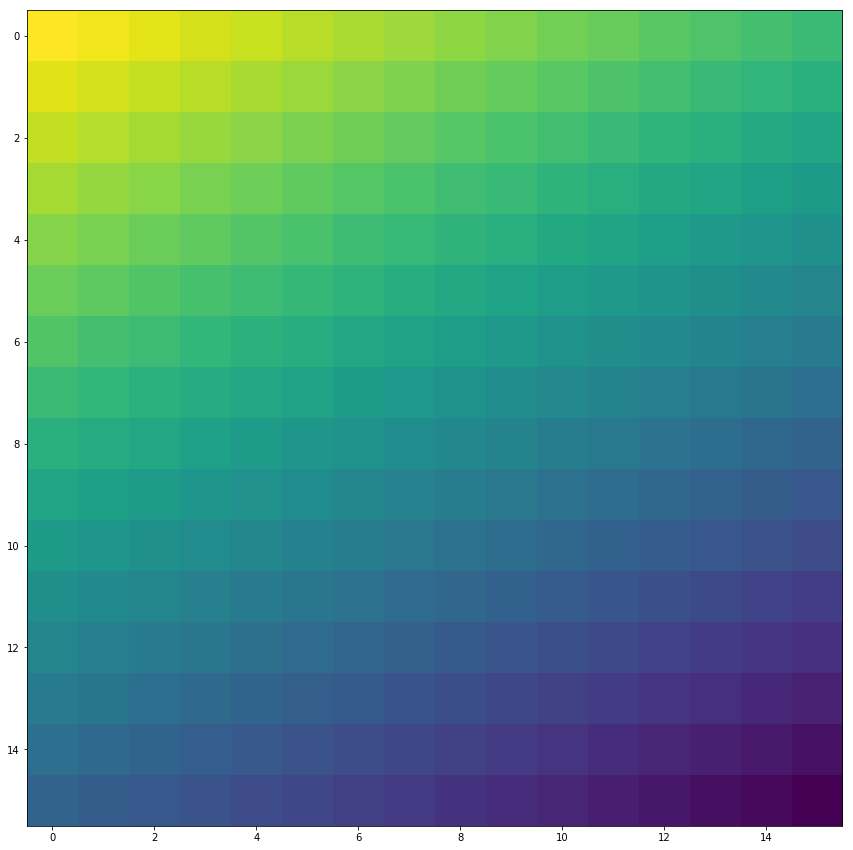

In [34]:
test_image.rotation = tf.convert_to_tensor(50.)

plt.figure(figsize=(15,15))
# plt.imshow(warped_image_sparse(test_image, False, False))
plt.imshow(warped_image(test_image, False, False))

In [ ]:
%prun -l 20 -s cumulative demons_register(images[0], images[1])